# ***Data Science Project: Activity prediction for chemical compounds*** 

**ID2214 Team 13**

- Christian Durán García - chdg@kth.se
- Kailin Wu - kailinw@kth.se

### Declaration
By submitting this solution, it is hereby declared that all individuals listed above have contributed to the solution, either with code that appear in the final solution below, or with code that has been evaluated and compared to the final solution, but for some reason has been excluded. It is also declared that all project members fully understand all parts of the final solution and can explain it upon request.

It is furthermore declared that the code below is a contribution by the project members only, and specifically that no part of the solution has been copied from any other source (except for lecture slides at the course ID2214/FID3214) and no part of the solution has been provided by someone not listed as project member above.

In [2]:
# Importing preliminary libraries for data exploration and manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

## **Data Collection**

In [3]:
# Reading data into dataframes
train_df = pd.read_csv('training_smiles.csv')
test_df = pd.read_csv('test_smiles.csv')

# Change the ACTIVE feature to category
train_df['ACTIVE'] = train_df['ACTIVE'].astype('int').astype('category')

# Display the dataframes
display(train_df.head())
display(test_df.head())

,INDEX,SMILES,ACTIVE
0,1,CCCc1sc(N)nc1-c1ccc(C)cc1,0
1,2,CCCCNC(=O)Cn1cnc2c(cnn2-c2ccc(C)c(C)c2)c1=O,0
2,3,O=C(NCCC1=CCCCC1)C1CCN(S(=O)(=O)N2CCOCC2)CC1,0
3,4,N#Cc1c(-c2c(Cl)cccc2Cl)noc1/C=C/Nc1ccc(C(=O)O)cc1,0
4,5,Cc1cc(C)cc(OCC(=O)Nc2ccc(F)cc2)c1,0


,INDEX,SMILES
0,153231,O=C(N/N=C\c1cccc(Br)c1)c1ccccc1-n1cccc1
1,153232,CCOc1ccc(/C=N/NC(=O)c2nnn(-c3nonc3N)c2COc2ccc(...
2,153233,Cc1cc2nc(Cl)c(Cl)nc2cc1C
3,153234,O=C1NC(=S)N/C1=C/c1cc([N+](=O)[O-])ccc1N1CCOCC1
4,153235,Cc1c(C(=O)OCC(=O)C(C#N)=C2Nc3ccccc3N2)oc2ccccc12


### *Extracting Features*

In [4]:
# Importing rdkit and using it to get all possible features from SMILES strings
from rdkit import Chem
from rdkit.Chem import Descriptors, Fragments, Lipinski, AllChem

### Extracting Features from SMILES

def get_descriptors(smiles):
    # Get mol
    mol = Chem.MolFromSmiles(smiles)
    if mol is None: # if none existent then None
        return None
    
    # Names of important descriptors
    descriptor_names = {
        'exact_mol_weight':'ExactMolWt',
        'tpsa':'TPSA',
        'LogP':'MolLogP'
    }

    # Lipinki descriptors names
    lipinski_names = {
        'heavy_atom_count':'HeavyAtomCount',
        'rotatable_bonds':'NumRotatableBonds',
        'hydrogen_bond_donors':'NumHDonors',
        'hydrogen_bond_acceptors':'NumHAcceptors',
    }

    # Fragment Based names
    fragment_names = {
        'functional_group_count':'fr_Al_COO'
    }

    # Get all the feature names
    feature_names = list(descriptor_names.keys()) + list(lipinski_names.keys()) + list(fragment_names.keys())

    # Extract features from smiles depending on descriptors names
    descriptors = [getattr(Descriptors, attr)(mol) for attr in list(descriptor_names.values())]
    descriptors = descriptors + [getattr(Lipinski, attr)(mol) for attr in list(lipinski_names.values())]
    descriptors = descriptors + [getattr(Fragments, attr)(mol) for attr in list(fragment_names.values())]

    # Create a dataframe based on the descriptors
    features_df = pd.DataFrame([descriptors], columns=feature_names)

    # Get the morgan fingerprints and add them as OneHotEncoded
    morgan_fp = pd.DataFrame(np.array(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024))).T

    # Concatenate the morgan fingerprints to the actual dataframe
    features_df = pd.concat([features_df, morgan_fp], axis=1)

    return features_df

def get_SMILES_features(df, dataset):
    # Generate a list of all the dictionaries with all the descriptors for that SMILES text
    features = [get_descriptors(smiles) for smiles in df['SMILES']]

    # Create a dataframe with all the features
    features_df = pd.concat(features)

    # Reset the index
    features_df = features_df.reset_index(drop=True)
    
    # Concatenate the features to the existing dataframe
    merged_df = pd.merge(df, features_df, left_index=True, right_index=True, how='inner')

    # Rearrange the order of the columns for the new dataframe
    if dataset == 'training':
        merged_df = merged_df[['INDEX', 'SMILES'] + features_df.columns.tolist() + ['ACTIVE']]
    elif dataset == 'testing':
        merged_df = merged_df[['INDEX', 'SMILES'] + features_df.columns.tolist()]

    return merged_df

train_df = get_SMILES_features(train_df, dataset='training')
test_df = get_SMILES_features(test_df, dataset='testing')

In [5]:
train_df['ACTIVE'] = train_df['ACTIVE'].astype('category')

display(train_df.head())
display(test_df.head())

,INDEX,SMILES,exact_mol_weight,tpsa,LogP,heavy_atom_count,rotatable_bonds,hydrogen_bond_donors,hydrogen_bond_acceptors,functional_group_count,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,

,INDEX,SMILES,exact_mol_weight,tpsa,LogP,heavy_atom_count,rotatable_bonds,hydrogen_bond_donors,hydrogen_bond_acceptors,functional_group_count,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,

## **EDA**

In [3]:
# Get descriptive statistics based on classes
train_df.iloc[:,[2,3,4,5,6,7,8,9,-1]].groupby('ACTIVE').describe()

exact_mol_weight                                                 \
                  count        mean        std         min         25%   
ACTIVE                                                                   
0              151446.0  349.100272  80.566118   32.026215  294.169191   
1                1784.0  363.755957  90.254938  155.026855  307.820272   

                                                 tpsa                        \
               50%         75%          max     count       mean        std   
ACTIVE                                                                        
0       345.125946  400.120526  1766.302831  151446.0  72.853486  28.562159   
1       356.067752  410.460342  1281.640711    1784.0  70.657455  34.365314   

                                               LogP                      \
        min    25%     50%    75%     max     count      mean       std   
ACTIVE                                                                    
0       0.0  54.02  70.750  89.35  878.39  151446.0  2.895087  1.276034   
1       0.0  50.44  68.055  88.40  447.33    1784.0  3.442377  1.368457   

                                                      heavy_atom_count  \
            min       25%     50%       75%       max            count   
ACTIVE                                                                   
0      -18.5803  2.112725  2.9349  3.725915  16.42850         151446.0   
1       -3.1680  2.637570  3.5048  4.314455  13.74388           1784.0   

                                                          rotatable_bonds  \
             mean       std  min   25%   50%   75%    max           count   
ACTIVE                                                                      
0       24.403246  5.714639  2.0  21.0  24.0  28.0  117.0        151446.0   
1       25.334081  6.406359  7.0  21.0  25.0  29.0   93.0          1784.0   

                                                     hydrogen_bond_donors  \
            mean       std  min  25%  50%  75%   max                count   
ACTIVE                                                                      
0       4.795663  2.348628  0.0  3.0  5.0  6.0  47.0             151446.0   
1       4.501682  2.428795  0.0  3.0  4.0  6.0  32.0               1784.0   

                                                     hydrogen_bond_acceptors  \
            mean       std  min  25%  50%  75%   max                   count   
ACTIVE                                                                         
0       1.139442  0.906997  0.0  1.0  1.0  2.0  24.0                151446.0   
1       1.106502  1.094463  0.0  0.0  1.0  2.0  16.0                  1784.0   

                                                     functional_group_count  \
            mean       std  min  25%  50%  75%   max                  count   
ACTIVE                                                                        
0       4.886719  1.889926  0.0  4.0  5.0  6.0  50.0               151446.0   
1       4.895740  2.186304  0.0  3.0  5.0  6.0  26.0                 1784.0   

                                                     
            mean       std  min  25%  50%  75%  max  
ACTIVE                                               
0       0.032804  0.187831  0.0  0.0  0.0  0.0  5.0  
1       0.008969  0.129403  0.0  0.0  0.0  0.0  4.0

From this instance is clear to state that there is an important class imbalance between 0's and 1's and most of the variables selected have a similar behavior regarding its descriptive statistics, except for several cases where the until the 3rd quartile the data behaves the same, and it is in the last 25% of the ordered data where there is a significant difference; most of the time label 1 has lower values.

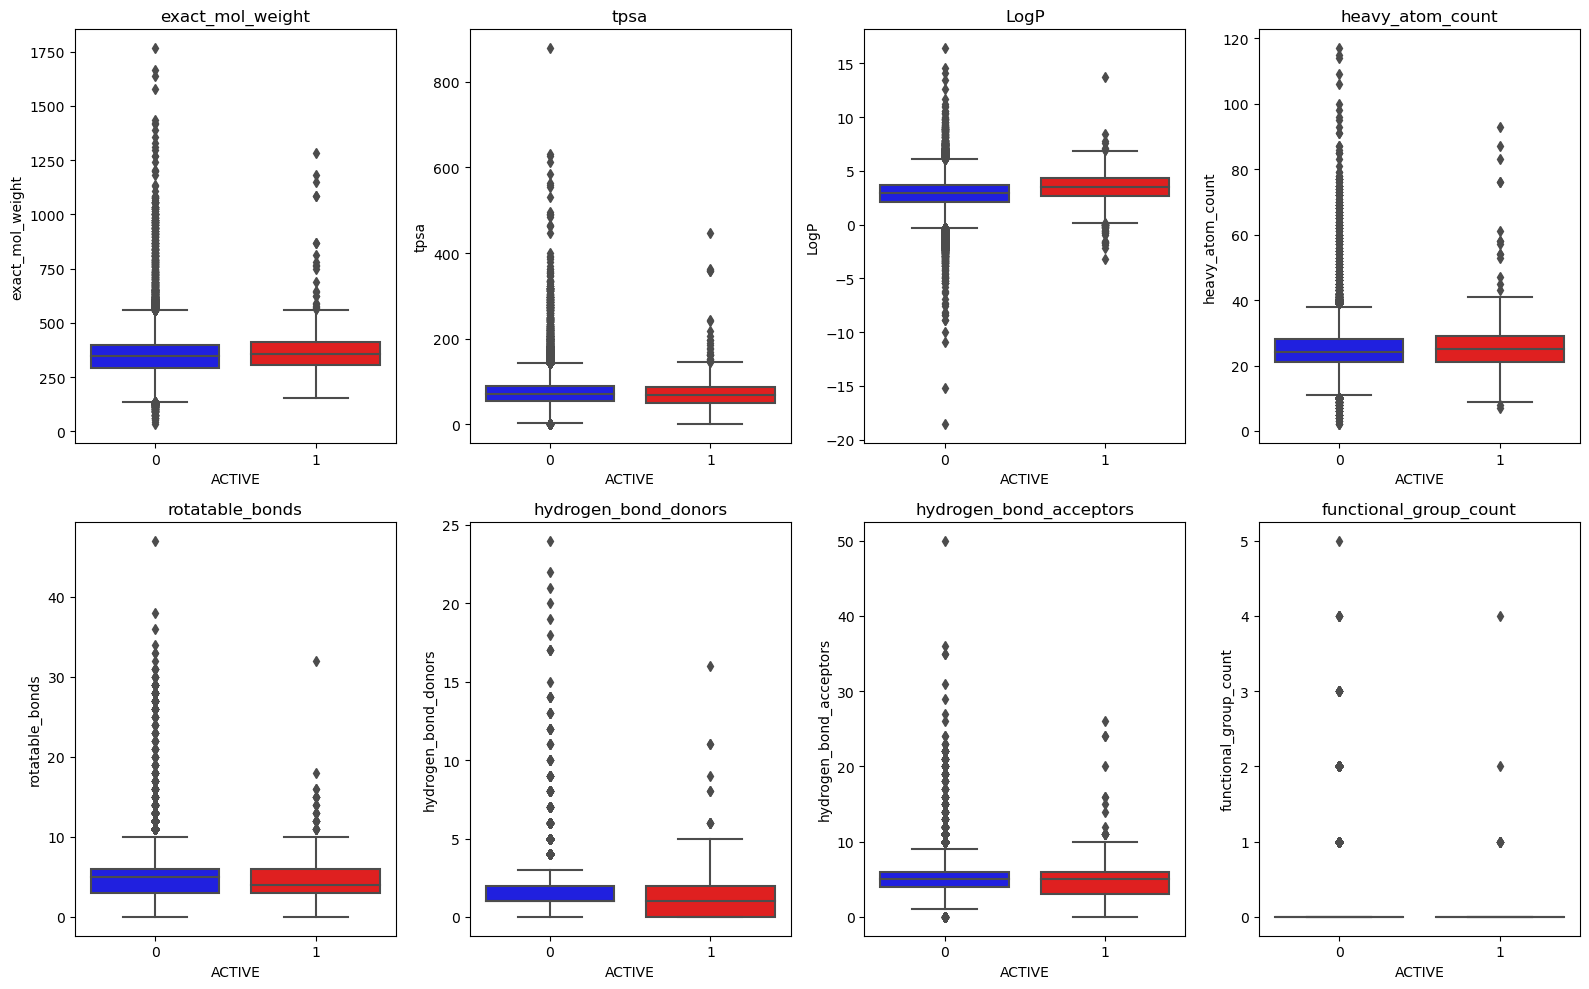

In [4]:
# Create subplots
fig, ax = plt.subplots(2, 4, figsize=(16,5*2))

# Select column to plot
cols = train_df.columns[[2,3,4,5,6,7,8,9]].to_numpy().reshape((2,4))

# Create for loop
for i in range(2):
    for j in range(4):
        sns.boxplot(x='ACTIVE', y=cols[i,j], data=train_df, palette={0:'blue', 1:'red'}, ax=ax[i,j])
        ax[i,j].set_title(cols[i,j])

plt.tight_layout()
plt.show()

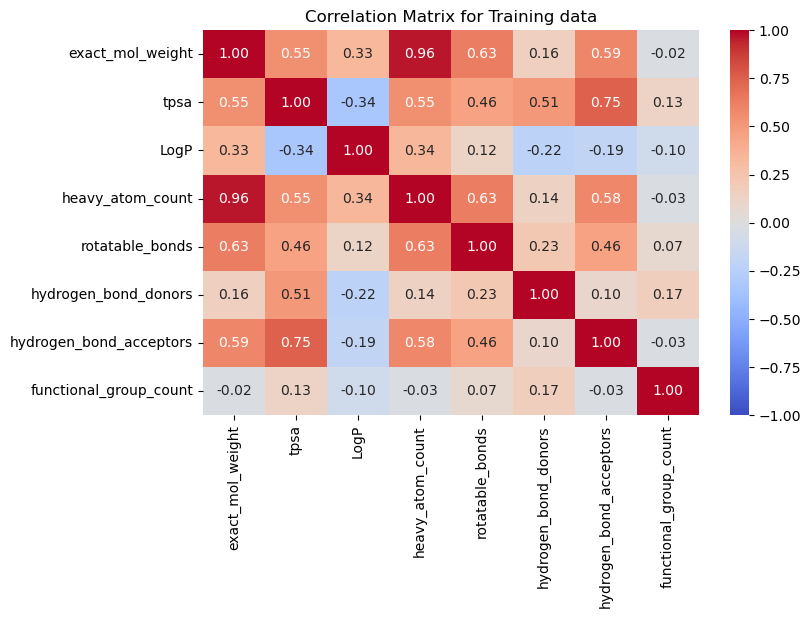

In [5]:
# Create a heatmap
plt.figure(figsize=(8,5))

sns.heatmap(train_df.iloc[:,[2,3,4,5,6,7,8,9]].corr(), annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix for Training data')

plt.show()

## **Data Preprocessing**

In [6]:
# Import necessary libraries to perform data preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

# Selecting columns to perform transformation
col_order = train_df.columns.tolist()
cols_to_keep = ['INDEX', 'SMILES', 'ACTIVE']
cols_to_pca = train_df.columns[10:-1].tolist()
cols_to_scale = train_df.columns[2:10].tolist()

n_components_pca = 10

# Create a column transformer to perform transformations for variables within a dataframe
ct = ColumnTransformer([
    ('scaler', StandardScaler(), cols_to_scale), # Scale numerical features
    ('pca', PCA(n_components=n_components_pca), cols_to_pca),
    ('pass', 'passthrough', cols_to_keep) # Keep columns INDEX and SMILES
], remainder='passthrough', verbose_feature_names_out=False).set_output(transform='pandas')

# Define the column order
col_order = train_df.columns[:10].tolist() + ['pca' + str(i) for i in range(n_components_pca)] + ['ACTIVE']

# Add a dummy column to use column transformer
test_df['ACTIVE'] = 0

# Apply the column transformations for the data
train_df_transformed = ct.fit_transform(train_df)[col_order]
test_df_transformed = ct.transform(test_df)[col_order[:-1]]

# Drop the dummy column
test_df.drop('ACTIVE', axis=1, inplace=True)

display(train_df_transformed.head())
display(test_df_transformed.head())

,INDEX,SMILES,exact_mol_weight,tpsa,LogP,heavy_atom_count,rotatable_bonds,hydrogen_bond_donors,hydrogen_bond_acceptors,functional_group_count,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,ACTIVE
0,1,CCCc1sc(N)nc1-c1ccc(C)cc1,-1.451883,-1.184399,0.588008,-1.469965,-0.762729,-0.152913,-0.996406,-0.173685,-0.580759,-1.304456,0.772717,1.158868,1.424168,-0.346934,0.424849,-0.015015,-0.479488,0.329416,0
1,2,CCCCNC(=O)Cn1cnc2c(cnn2-c2ccc(C)c(C)c2)c1=O,0.048504,0.313650,-0.614882,0.277064,0.513990,-0.152913,0.587853,-0.173685,0.402637,-0.296652,0.065449,-0.306927,1.531529,-0.023505,0.551853,0.866180,0.327383,-0.600843,0
2,3,O=C(NCCC1=CCCCC1)C1CCN(S(=O)(=O)N2CCOCC2)CC1,0.445260,0.213780,-1.266620,0.277064,0.513990,-0.152913,-0.468319,-0.173685,-0.958169,2.739658,-0.319524,-0.348095,0.193626,-0.191505,-0.241551,0.389109,-0.296612,1.184944,0
3,4,N#Cc1c(-c2c(Cl)cccc2Cl)noc1/C=C/Nc1ccc(C(=O)O)cc1,0.616439,0.919156,1.876921,0.451767,0.088417,0.946712,0.059767,-0.173685,0.023104,0.176094,-1.114428,0.862772,-0.697999,0.448417,-0.905398,-0.354669,0.366474,-0.345836,0
4,5,Cc1cc(C)cc(OCC(=O)Nc2ccc(F)cc2)c1,-0.943669,-1.204653,0.436908,-0.771153,-0.337156,-0.152913,-1.524492,-0.173685,1.770768,0.216818,-0.309765,0.670632,0.571256,-0.124251,0.119443,-0.284599,0.392015,-0.488182,0


,INDEX,SMILES,exact_mol_weight,tpsa,LogP,heavy_atom_count,rotatable_bonds,hydrogen_bond_donors,hydrogen_bond_acceptors,functional_group_count,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9
0,153231,O=C(N/N=C\c1cccc(Br)c1)c1ccccc1-n1cccc1,0.220087,-0.923201,0.862144,-0.247045,-0.337156,-0.152913,-0.996406,-0.173685,0.197503,-0.264755,-1.175809,0.340474,-1.041180,0.129061,-0.052097,-0.249825,-0.059837,-1.083241
1,153232,CCOc1ccc(/C=N/NC(=O)c2nnn(-c3nonc3N)c2COc2ccc(...,1.448326,2.889318,-0.616555,1.674688,1.790709,0.946712,3.228285,-0.173685,1.021750,-0.299949,0.454584,-0.145133,0.882163,-0.436402,-0.189725,-0.256850,0.414168,-0.237108
2,153233,Cc1cc2nc(Cl)c(Cl)nc2cc1C,-1.527434,-1.642893,0.509963,-1.819371,-2.039449,-1.252537,-1.524492,-0.173685,-0.379675,-0.890680,0.893276,1.747958,0.558439,0.117776,-0.398596,0.134481,0.376877,0.127096
3,153234,O=C1NC(=S)N/C1=C/c1cc([N+](=O)[O-])ccc1N1CCOCC1,-0.188318,0.835000,-1.662009,-0.247045,-0.762729,0.946712,0.587853,-0.173685,-1.764740,1.305693,0.703832,1.401650,-0.705441,0.233184,0.077295,0.770434,-0.857406,-1.444223
4,153235,Cc1c(C(=O)OCC(=O)C(C#N)=C2Nc3ccccc3N2)oc2ccccc12,0.295356,1.101087,0.655807,0.626470,-0.337156,0.946712,1.115940,-0.173685,0.114122,-0.633253,0.079808,-0.130449,0.078477,-1.189652,0.737051,0.487408,-0.599978,-0.276234


## **Model Selection**

In [7]:
# Import the necessary libraries for modeling, hyperparameter tunning, cross-valudation, and auc scoring
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV

# Import necessary libraries to address imbalance between classes
from imblearn.over_sampling import RandomOverSampler

### Experiment 1

#### Data Split and Oversampling

In [8]:
# Separating features from target variable
X = train_df_transformed.iloc[:,2:-1] # Features except INDEX, SMILES, ACTIVE
y = train_df_transformed.iloc[:,-1] # Target variable ACTIVE

# Use train test split to create training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y, random_state=42)

# Use random over sampler
X_resampled, y_resampled = RandomOverSampler(sampling_strategy='auto', random_state=42).fit_resample(X_train, y_train)

# Use train test split to create proper training and validation datasets
X_proper, X_val, y_proper, y_val = train_test_split(X_resampled, y_resampled, test_size=0.30, stratify=y_resampled, random_state=42)

# Print the shapes of each of the datasets
print(f"Size of training dataset: {X_train.shape}")
print(f"Size of testing dataset: {X_test.shape}")
print(f"Size of proper training dataset: {X_proper.shape}")
print(f"Size of validation dataset: {X_val.shape}")

# Print the value counts for ACTIVE target feature to show imbalance
print(f"\nValue counts for training target feature: {y_train.value_counts()}")
print(f"\nValue counts for testing target feature: {y_test.value_counts()}")
print(f"\nValue counts for proper training target feature: {y_proper.value_counts()}")
print(f"\nValue counts for validation target feature: {y_val.value_counts()}")

Size of training dataset: (107261, 18)
Size of testing dataset: (45969, 18)
Size of proper training dataset: (148416, 18)
Size of validation dataset: (63608, 18)

Value counts for training target feature: ACTIVE
0    106012
1      1249
Name: count, dtype: int64

Value counts for testing target feature: ACTIVE
0    45434
1      535
Name: count, dtype: int64

Value counts for proper training target feature: ACTIVE
0    74208
1    74208
Name: count, dtype: int64

Value counts for validation target feature: ACTIVE
0    31804
1    31804
Name: count, dtype: int64


In [7]:
# Set up learning algorithms and grid parameters for CV
rfc = RandomForestClassifier()

# Define parameter grids for hyperparameter tuning
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10],
    'max_features': ['log2', 'sqrt'],
    'criterion': ['gini', 'entropy'],
}

# Create the GridSearchCV Object
rfc_gscv = GridSearchCV(rfc, param_grid=param_grid_rf, scoring='roc_auc', cv=5, n_jobs=-1)

In [8]:
# Train the model with oversampling
rfc_gscv.fit(X_proper, y_proper)

# Get the best parameters for the classifier
print('Best parameters for RandomForestClassifier:')
print(rfc_gscv.best_params_)

# Extract the best model
rfc_best = rfc_gscv.best_estimator_

# Make predictions for validation set
y_pred_rfc = rfc_best.predict(X_val)
y_pred_rfc_proba = rfc_best.predict_proba(X_val)[:,1]

# Print classification report for validation dataset
print('Classification Report for Validation Dataset')
print(classification_report(y_val, y_pred_rfc))

# Calculate the auc score for validation dataset
print(f'ROC AUC Score for Validation Set: {roc_auc_score(y_val, y_pred_rfc_proba)}')

# Make predictions for testing dataset
y_pred_rfc_test = rfc_best.predict(X_test)
y_pred_rfc_proba_test = rfc_best.predict_proba(X_test)[:,1]

# Print classification report for testing dataset
print('Classification Report for Validation Dataset')
print(classification_report(y_test, y_pred_rfc_test))

# Calculate the auc score for testing dataset
print(f'ROC AUC Score for Validation Set: {roc_auc_score(y_test, y_pred_rfc_proba_test)}')

Best parameters for RandomForestClassifier:
{'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 100}
Classification Report for Validation Dataset
              precision    recall  f1-score   support

           0       0.85      0.99      0.92     31804
           1       0.97      0.65      0.78     15902

    accuracy                           0.88     47706
   macro avg       0.91      0.82      0.85     47706
weighted avg       0.89      0.88      0.87     47706

ROC AUC Score for Validation Set: 0.9699462898468437
Classification Report for Validation Dataset
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     45434
           1       0.08      0.09      0.08       535

    accuracy                           0.98     45969
   macro avg       0.54      0.54      0.54     45969
weighted avg       0.98      0.98      0.98     45969

ROC AUC Score for Validation Set: 0.718342905946759


In [11]:
# Testig the hyperparameter tuning with a model trained with more data and the test set
rfc_2 = RandomForestClassifier(criterion='gini', max_depth=10, max_features='log2', n_estimators=100)

rfc_2.fit(X_train, y_train)

y_pred_rfc_2 = rfc_2.predict(X_test)
y_pred_proba_rfc_2 = rfc_2.predict_proba(X_test)[:,1]

print(classification_report(y_test,y_pred_rfc_2))

print(f'ROC AUC Score: {roc_auc_score(y_test, y_pred_proba_rfc_2)}')

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     45434
           1       0.67      0.00      0.01       535

    accuracy                           0.99     45969
   macro avg       0.83      0.50      0.50     45969
weighted avg       0.98      0.99      0.98     45969

ROC AUC Score: 0.7076186305368906


In [9]:
# Set up learning algorithms and grid parameters for CV
gbc = GradientBoostingClassifier()

# Define parameter grids for hyperparameter tuning
param_grid_gb = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1],
    'max_depth': [5, 10],
    'max_features': ['log2', 'sqrt'],
    'subsample': [0.8, 0.9],
}

# Create the GridSearchCV Object
gbc_gscv = GridSearchCV(gbc, param_grid=param_grid_gb, scoring='roc_auc', cv=5, n_jobs=-1)

In [10]:
# Train the model with oversampling
gbc_gscv.fit(X_proper, y_proper)

# Get the best parameters for the classifier
print('Best parameters for RandomForestClassifier: ', gbc_gscv.best_params_)

# Extract the best model
gbc_best = gbc_gscv.best_estimator_

# Make predictions for validation set
y_pred_gbc = gbc_best.predict(X_val)
y_pred_gbc_proba = gbc_best.predict_proba(X_val)[:,1]

# Print classification report for validation dataset
print('Classification Report for Validation Dataset')
print(classification_report(y_val, y_pred_gbc))

# Calculate the auc score for validation dataset
print(f'ROC AUC Score for Validation Set: {roc_auc_score(y_val, y_pred_gbc_proba)}')

# Make predictions for testing dataset
y_pred_gbc_test = gbc_best.predict(X_test)
y_pred_gbc_proba_test = gbc_best.predict_proba(X_test)[:,1]

# Print classification report for testing dataset
print('Classification Report for Validation Dataset')
print(classification_report(y_test, y_pred_gbc_test))

# Calculate the auc score for testing dataset
print(f'ROC AUC Score for Validation Set: {roc_auc_score(y_test, y_pred_gbc_proba_test)}')

Best parameters for RandomForestClassifier:  {'learning_rate': 0.1, 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100, 'subsample': 0.9}
Classification Report for Validation Dataset
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     31804
           1       1.00      1.00      1.00     15902

    accuracy                           1.00     47706
   macro avg       1.00      1.00      1.00     47706
weighted avg       1.00      1.00      1.00     47706

ROC AUC Score for Validation Set: 0.9999351494195495
Classification Report for Validation Dataset
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     45434
           1       0.18      0.04      0.07       535

    accuracy                           0.99     45969
   macro avg       0.58      0.52      0.53     45969
weighted avg       0.98      0.99      0.98     45969

ROC AUC Score for Validation Set: 0.6812226135559067


In [12]:
# Testig the hyperparameter tuning with a model trained with more data and the test set
gbc_2 = GradientBoostingClassifier(learning_rate=0.1, max_depth=10, max_features='sqrt', n_estimators=100, subsample=0.9)

gbc_2.fit(X_train, y_train)

y_pred_gbc_2 = gbc_2.predict(X_test)
y_pred_proba_gbc_2 = gbc_2.predict_proba(X_test)[:,1]

print(classification_report(y_test,y_pred_gbc_2))

print(f'ROC AUC Score: {roc_auc_score(y_test, y_pred_proba_gbc_2)}')

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     45434
           1       0.06      0.03      0.04       535

    accuracy                           0.98     45969
   macro avg       0.52      0.51      0.52     45969
weighted avg       0.98      0.98      0.98     45969

ROC AUC Score: 0.7031794090555099


In [13]:
# Set up learning algorithms and grid parameters for CV
mlp = MLPClassifier()

# Define parameter grids for hyperparameter tuning
param_grid_mlp = {
    'hidden_layer_sizes': [(50,50), (50,100)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001],
    'early_stopping': [True],
    'validation_fraction': [0.1, 0.2]
}
# Create the GridSearchCV Object
mlp_gscv = GridSearchCV(mlp, param_grid=param_grid_mlp, scoring='roc_auc', cv=5, n_jobs=-1)

In [14]:
# Train the model with oversampling
mlp_gscv.fit(X_proper, y_proper)

# Get the best parameters for the classifier
print('Best parameters for RandomForestClassifier: ', mlp_gscv.best_params_)

# Extract the best model
mlp_best = mlp_gscv.best_estimator_

# Make predictions for validation set
y_pred_mlp = mlp_best.predict(X_val)
y_pred_mlp_proba = mlp_best.predict_proba(X_val)[:,1]

# Print classification report for validation dataset
print('Classification Report for Validation Dataset')
print(classification_report(y_val, y_pred_mlp))

# Calculate the auc score for validation dataset
print(f'ROC AUC Score for Validation Set: {roc_auc_score(y_val, y_pred_mlp_proba)}')

# Make predictions for testing dataset
y_pred_mlp_test = mlp_best.predict(X_test)
y_pred_mlp_proba_test = mlp_best.predict_proba(X_test)[:,1]

# Print classification report for testing dataset
print('Classification Report for Validation Dataset')
print(classification_report(y_test, y_pred_mlp_test))

# Calculate the auc score for testing dataset
print(f'ROC AUC Score for Validation Set: {roc_auc_score(y_test, y_pred_mlp_proba_test)}')

Best parameters for RandomForestClassifier:  {'activation': 'tanh', 'alpha': 0.001, 'early_stopping': True, 'hidden_layer_sizes': (50, 100), 'validation_fraction': 0.1}
Classification Report for Validation Dataset
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     31804
           1       0.96      1.00      0.98     15902

    accuracy                           0.99     47706
   macro avg       0.98      0.99      0.98     47706
weighted avg       0.99      0.99      0.99     47706

ROC AUC Score for Validation Set: 0.9957189501676893
Classification Report for Validation Dataset
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     45434
           1       0.06      0.11      0.08       535

    accuracy                           0.97     45969
   macro avg       0.53      0.55      0.53     45969
weighted avg       0.98      0.97      0.97     45969

ROC AUC Score for Validation Set: 

In [15]:
# Testig the hyperparameter tuning with a model trained with more data and the test set
mlp_2 = MLPClassifier(activation='tanh', alpha=0.001, early_stopping=True, hidden_layer_sizes=(50, 100), validation_fraction=0.1)

mlp_2.fit(X_train, y_train)

y_pred_mlp_2 = mlp_2.predict(X_test)
y_pred_proba_mlp_2 = mlp_2.predict_proba(X_test)[:,1]

print(classification_report(y_test,y_pred_mlp_2))

print(f'ROC AUC Score: {roc_auc_score(y_test, y_pred_proba_mlp_2)}')

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     45434
           1       0.00      0.00      0.00       535

    accuracy                           0.99     45969
   macro avg       0.49      0.50      0.50     45969
weighted avg       0.98      0.99      0.98     45969

ROC AUC Score: 0.6977192962246973


In [54]:
# Create a deep neural network Using TensorFlow
import keras
from keras import Sequential
from keras.layers import Dense
from scikeras.wrappers import KerasClassifier

# Define a function to create the Keras Model
def create_model(hl1, hl2, hl3, activation, solver):
    model = Sequential()
    model.add(Dense(hl1, input_dim=X_proper.shape[1], activation=activation))
    model.add(Dense(hl2, activation=activation))
    model.add(Dense(hl3, activation=activation))
    model.add(Dense(1, activation='sigmoid'))  # Assuming 10 classes for classification
    model.compile(optimizer=solver, loss='binary_crossentropy', metrics=[keras.metrics.AUC()])
    return model

# Create Keras Wrapper to use GridSearchCV
model = KerasClassifier(build_fn=create_model, epochs=20, batch_size=32, verbose=0, activation='relu', solver='adam',
                        hl1=50, hl2=30, hl3=10)

# Define the hyperparameter grid
param_grid = {
    'hl1': [50, 100],
    'hl2': [30, 50],
    'hl3': [10, 20],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd']
}

# Use GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

# Perform the grid search
grid_result = grid_search.fit(X_proper, y_proper)

# Print the best parameters and corresponding AUC
print(f"Best Parameters: {grid_result.best_params_}")
print(f"Best AUC: {grid_result.best_score_}")

# Print classification report and auc on unseen data
best_model_nn = grid_result.best_estimator_

Best Parameters: {'activation': 'tanh', 'hl1': 100, 'hl2': 50, 'hl3': 20, 'solver': 'adam'}
Best AUC: 0.995159689932321


In [56]:
# Performance on unseen data
y_pred_nn = best_model_nn.predict(X_test)
y_pred_nn_proba = best_model_nn.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred_nn))
print(f'\nAUC Score on Unseen Data: {roc_auc_score(y_test, y_pred_nn_proba)}')

              precision    recall  f1-score   support

           0       0.99      0.97      0.98     45434
           1       0.05      0.11      0.07       535

    accuracy                           0.96     45969
   macro avg       0.52      0.54      0.52     45969
weighted avg       0.98      0.96      0.97     45969


AUC Score on Unseen Data: 0.6611742451513317


#### Experiment 2

In [37]:
# Import necessary libraries to perform data preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import KBinsDiscretizer

# Selecting columns to perform transformation
col_order = train_df.columns.tolist()
cols_to_keep = ['INDEX', 'SMILES', 'ACTIVE']
cols_to_pca = train_df.columns[10:-1].tolist()
cols_to_scale = train_df.columns[2:10].tolist()

n_components_pca = 10

# Create a column transformer to perform transformations for variables within a dataframe
ct = ColumnTransformer([
    ('scaler', KBinsDiscretizer(encode='ordinal', strategy='quantile'), cols_to_scale), # Scale numerical features
    ('pca', PCA(n_components=n_components_pca), cols_to_pca),
    ('pass', 'passthrough', cols_to_keep) # Keep columns INDEX and SMILES
], remainder='passthrough', verbose_feature_names_out=False).set_output(transform='pandas')

# Define the column order
col_order = train_df.columns[:10].tolist() + ['pca' + str(i) for i in range(n_components_pca)] + ['ACTIVE']

# Add a dummy column to use column transformer
test_df['ACTIVE'] = 0

# Apply the column transformations for the data
train_df_transformed = ct.fit_transform(train_df)[col_order]
test_df_transformed = ct.transform(test_df)[col_order[:-1]]

# Drop the dummy column
test_df.drop('ACTIVE', axis=1, inplace=True)

display(train_df_transformed.head())
display(test_df_transformed.head())

,INDEX,SMILES,exact_mol_weight,tpsa,LogP,heavy_atom_count,rotatable_bonds,hydrogen_bond_donors,hydrogen_bond_acceptors,functional_group_count,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,ACTIVE
0,1,CCCc1sc(N)nc1-c1ccc(C)cc1,0.0,0.0,3.0,0.0,1.0,1.0,1.0,0.0,-0.580550,-1.304447,0.772960,1.161989,1.424065,-0.334070,0.401459,-0.076314,-0.489705,0.314912,0
1,2,CCCCNC(=O)Cn1cnc2c(cnn2-c2ccc(C)c(C)c2)c1=O,2.0,3.0,1.0,3.0,3.0,1.0,4.0,0.0,0.402441,-0.296986,0.064853,-0.308483,1.533473,-0.043534,0.558903,0.923704,0.321653,-0.579229,0
2,3,O=C(NCCC1=CCCCC1)C1CCN(S(=O)(=O)N2CCOCC2)CC1,3.0,3.0,0.0,3.0,3.0,1.0,2.0,0.0,-0.958338,2.739503,-0.319632,-0.349254,0.194642,-0.192214,-0.240888,0.368406,-0.308019,1.152384,0
3,4,N#Cc1c(-c2c(Cl)cccc2Cl)noc1/C=C/Nc1ccc(C(=O)O)cc1,3.0,4.0,4.0,3.0,3.0,2.0,3.0,0.0,0.022913,0.176416,-1.113986,0.859458,-0.700015,0.441468,-0.886347,-0.351122,0.372026,-0.333642,0
4,5,Cc1cc(C)cc(OCC(=O)Nc2ccc(F)cc2)c1,0.0,0.0,3.0,1.0,2.0,1.0,0.0,0.0,1.770938,0.217479,-0.308265,0.673485,0.556048,-0.086150,0.106184,-0.406338,0.336469,-0.523833,0


,INDEX,SMILES,exact_mol_weight,tpsa,LogP,heavy_atom_count,rotatable_bonds,hydrogen_bond_donors,hydrogen_bond_acceptors,functional_group_count,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9
0,153231,O=C(N/N=C\c1cccc(Br)c1)c1ccccc1-n1cccc1,3.0,0.0,4.0,2.0,2.0,1.0,1.0,0.0,0.197454,-0.264669,-1.175749,0.338996,-1.039420,0.131617,-0.030832,-0.241313,-0.048103,-1.094993
1,153232,CCOc1ccc(/C=N/NC(=O)c2nnn(-c3nonc3N)c2COc2ccc(...,4.0,4.0,1.0,4.0,4.0,2.0,4.0,0.0,1.021793,-0.299610,0.455129,-0.144503,0.876610,-0.429424,-0.205025,-0.309847,0.377647,-0.174395
2,153233,Cc1cc2nc(Cl)c(Cl)nc2cc1C,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,-0.379684,-0.890713,0.893241,1.747374,0.559837,0.114455,-0.395334,0.144851,0.384362,0.126695
3,153234,O=C1NC(=S)N/C1=C/c1cc([N+](=O)[O-])ccc1N1CCOCC1,2.0,4.0,0.0,2.0,1.0,2.0,4.0,0.0,-1.764677,1.305528,0.703685,1.403194,-0.700595,0.231359,0.053384,0.790130,-0.846885,-1.416712
4,153235,Cc1c(C(=O)OCC(=O)C(C#N)=C2Nc3ccccc3N2)oc2ccccc12,3.0,4.0,3.0,3.0,2.0,2.0,4.0,0.0,0.114139,-0.633309,0.079779,-0.129131,0.079715,-1.183957,0.725859,0.469237,-0.613857,-0.285275


In [38]:
# Separating features from target variable
X = train_df_transformed.iloc[:,2:-1] # Features except INDEX, SMILES, ACTIVE or Morgan Fingerprints
y = train_df_transformed.iloc[:,-1] # Target variable ACTIVE

# Use train test split to create training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y, random_state=42)

# Use random over sampler
X_resampled, y_resampled = RandomOverSampler(sampling_strategy='auto', random_state=42).fit_resample(X_train, y_train)

# Use train test split to create proper training and validation datasets
X_proper, X_val, y_proper, y_val = train_test_split(X_resampled, y_resampled, test_size=0.30, stratify=y_resampled, random_state=42)

# Print the shapes of each of the datasets
print(f"Size of training dataset: {X_train.shape}")
print(f"Size of testing dataset: {X_test.shape}")
print(f"Size of proper training dataset: {X_proper.shape}")
print(f"Size of validation dataset: {X_val.shape}")

# Print the value counts for ACTIVE target feature to show imbalance
print(f"\nValue counts for training target feature: {y_train.value_counts()}")
print(f"\nValue counts for testing target feature: {y_test.value_counts()}")
print(f"\nValue counts for proper training target feature: {y_proper.value_counts()}")
print(f"\nValue counts for validation target feature: {y_val.value_counts()}")

Size of training dataset: (107261, 18)
Size of testing dataset: (45969, 18)
Size of proper training dataset: (148416, 18)
Size of validation dataset: (63608, 18)

Value counts for training target feature: ACTIVE
0    106012
1      1249
Name: count, dtype: int64

Value counts for testing target feature: ACTIVE
0    45434
1      535
Name: count, dtype: int64

Value counts for proper training target feature: ACTIVE
0    74208
1    74208
Name: count, dtype: int64

Value counts for validation target feature: ACTIVE
0    31804
1    31804
Name: count, dtype: int64


In [35]:
# Set up learning algorithms and grid parameters for CV
rfc_2 = RandomForestClassifier()

# Define parameter grids for hyperparameter tuning
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10],
    'max_features': ['log2', 'sqrt'],
    'criterion': ['gini', 'entropy'],
}

# Create the GridSearchCV Object
rfc_gscv_2 = GridSearchCV(rfc_2, param_grid=param_grid_rf, scoring='roc_auc', cv=5, n_jobs=-1)

In [39]:
# Train the model with oversampling
rfc_gscv_2.fit(X_proper, y_proper)

# Get the best parameters for the classifier
print('Best parameters for RandomForestClassifier:')
print(rfc_gscv_2.best_params_)

# Extract the best model
rfc_best_2 = rfc_gscv_2.best_estimator_

# Make predictions for validation set
y_pred_rfc_2 = rfc_best_2.predict(X_val)
y_pred_rfc_proba_2 = rfc_best_2.predict_proba(X_val)[:,1]

# Print classification report for validation dataset
print('Classification Report for Validation Dataset')
print(classification_report(y_val, y_pred_rfc_2))

# Calculate the auc score for validation dataset
print(f'ROC AUC Score for Validation Set: {roc_auc_score(y_val, y_pred_rfc_proba_2)}')

# Make predictions for testing dataset
y_pred_rfc_test_2 = rfc_best_2.predict(X_test)
y_pred_rfc_proba_test_2 = rfc_best_2.predict_proba(X_test)[:,1]

# Print classification report for testing dataset
print('Classification Report for Validation Dataset')
print(classification_report(y_test, y_pred_rfc_test_2))

# Calculate the auc score for testing dataset
print(f'ROC AUC Score for Validation Set: {roc_auc_score(y_test, y_pred_rfc_proba_test_2)}')

Best parameters for RandomForestClassifier:
{'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}
Classification Report for Validation Dataset
              precision    recall  f1-score   support

           0       0.96      0.87      0.91     31804
           1       0.88      0.96      0.92     31804

    accuracy                           0.92     63608
   macro avg       0.92      0.92      0.92     63608
weighted avg       0.92      0.92      0.92     63608

ROC AUC Score for Validation Set: 0.9763652427320964
Classification Report for Validation Dataset
              precision    recall  f1-score   support

           0       0.99      0.87      0.93     45434
           1       0.03      0.35      0.06       535

    accuracy                           0.87     45969
   macro avg       0.51      0.61      0.49     45969
weighted avg       0.98      0.87      0.92     45969

ROC AUC Score for Validation Set: 0.7122705051468311


In [40]:
# Set up learning algorithms and grid parameters for CV
gbc_2 = GradientBoostingClassifier()

# Define parameter grids for hyperparameter tuning
param_grid_gb = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1],
    'max_depth': [5, 10],
    'max_features': ['log2', 'sqrt'],
    'subsample': [0.8, 0.9],
}

# Create the GridSearchCV Object
gbc_gscv_2 = GridSearchCV(gbc_2, param_grid=param_grid_gb, scoring='roc_auc', cv=5, n_jobs=-1)

In [41]:
# Train the model with oversampling
gbc_gscv_2.fit(X_proper, y_proper)

# Get the best parameters for the classifier
print('Best parameters for RandomForestClassifier: ', gbc_gscv_2.best_params_)

# Extract the best model
gbc_best_2 = gbc_gscv_2.best_estimator_

# Make predictions for validation set
y_pred_gbc_2 = gbc_best_2.predict(X_val)
y_pred_gbc_proba_2 = gbc_best_2.predict_proba(X_val)[:,1]

# Print classification report for validation dataset
print('Classification Report for Validation Dataset')
print(classification_report(y_val, y_pred_gbc_2))

# Calculate the auc score for validation dataset
print(f'ROC AUC Score for Validation Set: {roc_auc_score(y_val, y_pred_gbc_proba_2)}')

# Make predictions for testing dataset
y_pred_gbc_test_2 = gbc_best_2.predict(X_test)
y_pred_gbc_proba_test_2 = gbc_best_2.predict_proba(X_test)[:,1]

# Print classification report for testing dataset
print('Classification Report for Validation Dataset')
print(classification_report(y_test, y_pred_gbc_test_2))

# Calculate the auc score for testing dataset
print(f'ROC AUC Score for Validation Set: {roc_auc_score(y_test, y_pred_gbc_proba_test_2)}')

Best parameters for RandomForestClassifier:  {'learning_rate': 0.1, 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 100, 'subsample': 0.8}
Classification Report for Validation Dataset
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     31804
           1       0.99      1.00      0.99     31804

    accuracy                           0.99     63608
   macro avg       0.99      0.99      0.99     63608
weighted avg       0.99      0.99      0.99     63608

ROC AUC Score for Validation Set: 0.9999758476175314
Classification Report for Validation Dataset
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     45434
           1       0.08      0.11      0.09       535

    accuracy                           0.97     45969
   macro avg       0.53      0.55      0.54     45969
weighted avg       0.98      0.97      0.98     45969

ROC AUC Score for Validation Set: 0.6841707535918385


In [43]:
import keras
from keras import Sequential
from keras.layers import Dense

# Generate keras model based on previous GridSearch
model_2 = Sequential()

# Generate keras model
model_2.add(Dense(50, input_dim=X_proper.shape[1], activation='tanh'))
model_2.add(Dense(30, activation='tanh'))
model_2.add(Dense(20, activation='tanh'))
model_2.add(Dense(1, activation='sigmoid'))  # Assuming 10 classes for classification
model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=[keras.metrics.AUC()])

# Train the model
model_2.fit(X_proper, y_proper, epochs=20, batch_size=32, validation_split=0.1, verbose=0)

# Evaluate the model
auc_val = model_2.evaluate(X_val, y_val, verbose=0)[1]
auc_test = model_2.evaluate(X_test, y_test, verbose=0)[1]

print(f'Validation AUC: {auc_val}')
print(f'Test AUC: {auc_test}')





Validation AUC: 0.9834038615226746
Test AUC: 0.6122301816940308


## **Results**

The best performing model based on AUC is RandomForestClassifier with an approximate of 0.71 AUC.

In [ ]:
# Save model to pickle file
import pickle as pkl

# Select best model
best_model_overall = rfc_gscv.best_estimator_

# Filepath to store model
model_path = 'SMILES_model.pkl'

# Dump the model in a file
with open(model_path, 'wb') as file:
    pkl.dump(best_model_overall, file)

In [22]:
import pickle as pkl

# Filepath to store model
model_path = 'SMILES_model.pkl'

# Read the model from the file
with open(model_path, 'rb') as file:
    best_model_overall = pkl.load(file)

# Use it to generate predictions and AUC
probas = best_model_overall.predict_proba(X_test)[:,1]

auc = roc_auc_score(y_test, probas)

print(f'AUC Score: {auc}')

AUC Score: 0.7187927728379957


In [14]:
# Get the feature importances
pd.Series(best_model_overall.feature_importances_, index=X_train.columns).sort_values(ascending=False)

LogP                       0.156858
pca3                       0.096696
pca1                       0.082638
tpsa                       0.075676
exact_mol_weight           0.064286
pca0                       0.062030
pca9                       0.056882
pca4                       0.051008
pca6                       0.050098
pca5                       0.049413
pca7                       0.048539
pca8                       0.045599
pca2                       0.045465
heavy_atom_count           0.036512
rotatable_bonds            0.034733
hydrogen_bond_acceptors    0.026487
hydrogen_bond_donors       0.012814
functional_group_count     0.004265
dtype: float64

In [30]:
# Create txt file with propabilities for the positive class for the testing data
probas_test = best_model_overall.predict_proba(test_df_transformed.iloc[:,2:])[:,1]

txt_path = '13.txt'

with open(txt_path, 'w') as file:
    file.write(str(np.round(auc, 2)) + '\n')

    for proba in probas_test:
        file.write(str(proba) + '\n')

predictions_df = pd.read_csv("13.txt", header=None)

display(predictions_df.head())

assert predictions_df.shape == (51077, 1)
assert np.all((predictions_df.values >= 0) & (predictions_df.values <= 1))

,0
0,0.720000
1,0.411375
2,0.120710
3,0.320384
4,0.170537
